In [2]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd


# visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt

In [3]:
# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

# Acquire

In [4]:
eth = pd.read_csv('ETH-USD.csv')

In [5]:
eth.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-08-08,2.793760,2.798810,0.714725,0.753325,0.753325,674188.0
1,2015-08-09,0.706136,0.879810,0.629191,0.701897,0.701897,532170.0
2,2015-08-10,0.713989,0.729854,0.636546,0.708448,0.708448,405283.0
3,2015-08-11,0.708087,1.131410,0.663235,1.067860,1.067860,1463100.0
4,2015-08-12,1.058750,1.289940,0.883608,1.217440,1.217440,2150620.0


In [6]:
eth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2120 entries, 0 to 2119
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2120 non-null   object 
 1   Open       2116 non-null   float64
 2   High       2116 non-null   float64
 3   Low        2116 non-null   float64
 4   Close      2116 non-null   float64
 5   Adj Close  2116 non-null   float64
 6   Volume     2116 non-null   float64
dtypes: float64(6), object(1)
memory usage: 116.1+ KB


In [7]:
# check for missing/null data
eth.isnull().sum()

Date         0
Open         4
High         4
Low          4
Close        4
Adj Close    4
Volume       4
dtype: int64

In [8]:
eth.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2116.000000,2116.000000,2116.000000,2116.000000,2116.000000,2.116000e+03
mean,345.996625,359.900218,330.685773,347.228301,347.228301,6.653876e+09
std,540.224970,566.906229,510.258962,542.654011,542.654011,1.035570e+10
min,0.431589,0.482988,0.420897,0.434829,0.434829,1.021280e+05
25%,13.281750,13.855525,13.032900,13.325150,13.325150,3.605552e+07
50%,194.705276,201.004501,187.054772,194.787369,194.787369,2.021149e+09
75%,371.200424,383.609542,363.656357,371.154121,371.154121,9.060469e+09
max,4174.635742,4362.350586,3785.848633,4168.701172,4168.701172,8.448291e+10


In [9]:
#check null rows
eth[eth['Open'].isna()]

,Date,Open,High,Low,Close,Adj Close,Volume
1714,2020-04-17,NaN,NaN,NaN,NaN,NaN,NaN
1889,2020-10-09,NaN,NaN,NaN,NaN,NaN,NaN
1892,2020-10-12,NaN,NaN,NaN,NaN,NaN,NaN
1893,2020-10-13,NaN,NaN,NaN,NaN,NaN,NaN


Note: Looks like all nulls in same rows. Considering the minimal amount of null values, I think a simple interopation would be acceptable here

# Prepare

In [10]:
# interpolate missing values 
eth = eth.interpolate(method='linear')

In [11]:
eth.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [12]:
eth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2120 entries, 0 to 2119
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2120 non-null   object 
 1   Open       2120 non-null   float64
 2   High       2120 non-null   float64
 3   Low        2120 non-null   float64
 4   Close      2120 non-null   float64
 5   Adj Close  2120 non-null   float64
 6   Volume     2120 non-null   float64
dtypes: float64(6), object(1)
memory usage: 116.1+ KB


In [13]:
# Date not in DateTime format.  Convert and set as index
eth.Date = pd.to_datetime(eth.Date)
eth = eth.set_index('Date').sort_index()

In [14]:
# compare Close and Adj Close.  Appear to be same info, need to confirm:
eth[eth['Close'] != eth['Adj Close']]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


In [15]:
# columns are equivalent so drop 'Adj Close'
eth = eth.drop(columns=('Adj Close'))

In [16]:
eth.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2120 entries, 2015-08-08 to 2021-05-27
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2120 non-null   float64
 1   High    2120 non-null   float64
 2   Low     2120 non-null   float64
 3   Close   2120 non-null   float64
 4   Volume  2120 non-null   float64
dtypes: float64(5)
memory usage: 99.4 KB


In [17]:
# Create Day-over-Day data columns
eth['close_DoD'] = eth.Close.diff()
eth['vol_DoD'] = eth.Volume.diff()

In [18]:
# Create Close 50, 100, 200 day rolling averages (Close & Volume)
rolling_df = eth.assign(
rolling_50C=lambda eth: eth.Close.rolling(50).mean(),
rolling_100C=lambda eth: eth.Close.rolling(100).mean(),
rolling_200C=lambda eth: eth.Close.rolling(200).mean(),
rolling_50V=lambda eth: eth.Volume.rolling(50).mean(),
rolling_100V=lambda eth: eth.Volume.rolling(100).mean(),
rolling_200V=lambda eth: eth.Volume.rolling(200).mean())

In [19]:
rolling_df.head()

,Open,High,Low,Close,Volume,close_DoD,vol_DoD,rolling_50C,rolling_100C,rolling_200C,rolling_50V,rolling_100V,rolling_200V
Date,,,,,,,,,,,,,
2015-08-08,2.793760,2.798810,0.714725,0.753325,674188.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-09,0.706136,0.879810,0.629191,0.701897,532170.0,-0.051428,-142018.0,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-10,0.713989,0.729854,0.636546,0.708448,405283.0,0.006551,-126887.0,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-11,0.708087,1.131410,0.663235,1.067860,1463100.0,0.359412,1057817.0,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-12,1.058750,1.289940,0.883608,1.217440,2150620.0,0.149580,687520.0,NaN,NaN,NaN,NaN,NaN,NaN


** Calculate RSI and add to eth

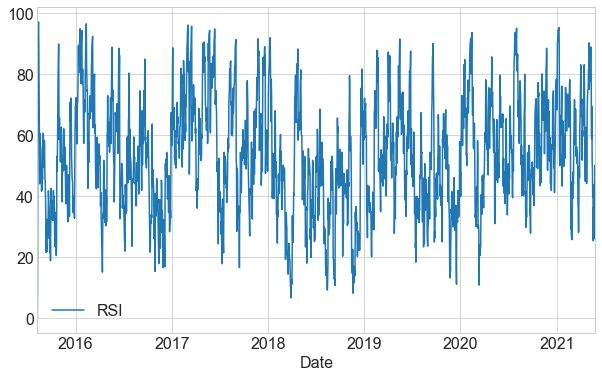

In [20]:
# Window length for moving average
window_length = 14

# Dates
start = eth.index.min()
end = eth.index.max()

# Get the difference in price from previous step
delta = eth.Close.diff()
# Get rid of the first row, which is NaN since it did not have a previous 
# row to calculate the differences
delta = delta[1:] 

# Make the positive gains (up) and negative gains (down) Series
up, down = delta.clip(lower=0), delta.clip(upper=0)

# Calculate the EWMA
roll_up1 = up.ewm(span=window_length).mean()
roll_down1 = down.abs().ewm(span=window_length).mean()

# Calculate the RSI based on EWMA
RS1 = roll_up1 / roll_down1
RSI1 = 100.0 - (100.0 / (1.0 + RS1))

# Calculate the SMA
roll_up2 = up.rolling(window_length).mean()
roll_down2 = down.abs().rolling(window_length).mean()

# Calculate the RSI based on SMA
RS2 = roll_up2 / roll_down2
RSI2 = 100.0 - (100.0 / (1.0 + RS2))

# Compare graphically
plt.figure(figsize=(10, 6))
RSI1.plot()
plt.legend(['RSI'])
plt.show()

In [21]:
# Add to rolling_df 
rolling_df['RSI'] = RSI1

In [22]:
rolling_df.tail()

,Open,High,Low,Close,Volume,close_DoD,vol_DoD,rolling_50C,rolling_100C,rolling_200C,rolling_50V,rolling_100V,rolling_200V,RSI
Date,,,,,,,,,,,,,,
2021-05-23,2298.367188,2384.411621,1737.468750,2109.579834,5.600572e+10,-186.125732,1.391578e+10,2787.276658,2269.132787,1582.527753,4.196180e+10,3.445602e+10,3.013594e+10,26.079356
2021-05-24,2099.936035,2672.595703,2090.639648,2643.591064,5.369712e+10,534.011230,-2.308600e+09,2798.286023,2277.427599,1593.675372,4.251561e+10,3.463940e+10,3.032722e+10,43.362985
2021-05-25,2649.033203,2750.534912,2394.355469,2706.628906,4.955833e+10,63.037842,-4.138788e+09,2810.260857,2286.443047,1604.934920,4.292899e+10,3.482059e+10,3.049132e+10,45.111032
2021-05-26,2707.052734,2911.735596,2652.094482,2888.698730,4.249977e+10,182.069824,-7.058567e+09,2825.667253,2297.532124,1617.199848,4.319453e+10,3.485603e+10,3.060946e+10,50.230240
2021-05-27,2872.692383,2872.692383,2642.607910,2776.133057,3.456504e+10,-112.565673,-7.934728e+09,2841.768369,2307.482780,1628.812739,4.316350e+10,3.485899e+10,3.072582e+10,47.096775


In [32]:
# Calculate and add Target +/- column
rolling_df['+/-'] = np.where(rolling_df.Close.diff() > 0, 1, 0) 

In [33]:
rolling_df.head()

,Open,High,Low,Close,Volume,close_DoD,vol_DoD,rolling_50C,rolling_100C,rolling_200C,rolling_50V,rolling_100V,rolling_200V,RSI,+/-
Date,,,,,,,,,,,,,,,
2015-08-08,2.793760,2.798810,0.714725,0.753325,674188.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2015-08-09,0.706136,0.879810,0.629191,0.701897,532170.0,-0.051428,-142018.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0
2015-08-10,0.713989,0.729854,0.636546,0.708448,405283.0,0.006551,-126887.0,NaN,NaN,NaN,NaN,NaN,NaN,12.814461,1
2015-08-11,0.708087,1.131410,0.663235,1.067860,1463100.0,0.359412,1057817.0,NaN,NaN,NaN,NaN,NaN,NaN,90.431892,1
2015-08-12,1.058750,1.289940,0.883608,1.217440,2150620.0,0.149580,687520.0,NaN,NaN,NaN,NaN,NaN,NaN,93.297332,1


# Explore

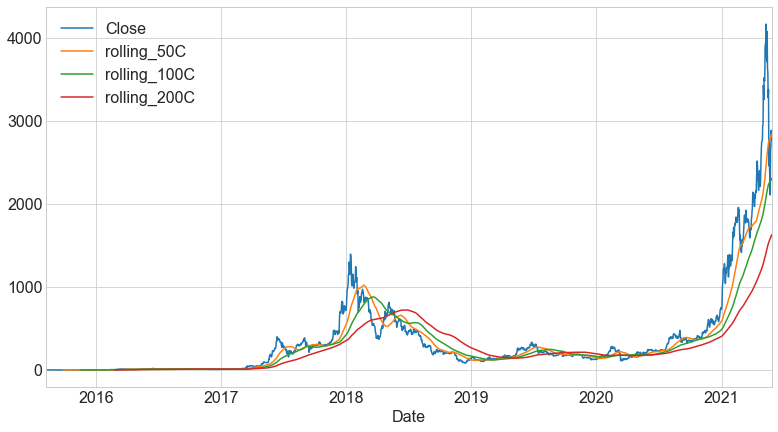

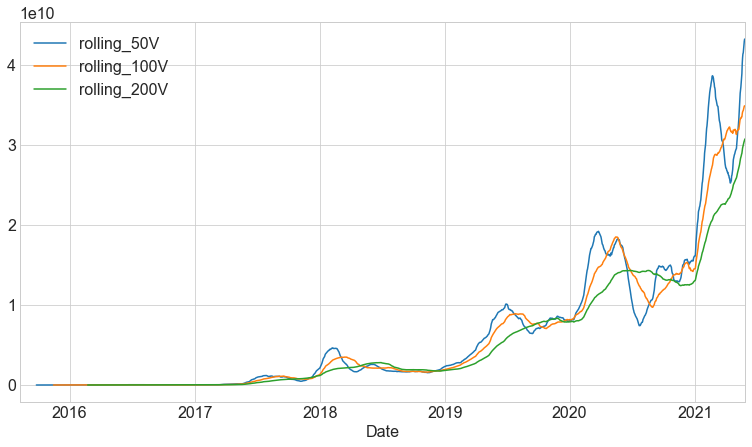

In [24]:
# Close vs rolling Volumes
rolling_df[['Close', 'rolling_50C', 'rolling_100C', 'rolling_200C']].plot()
rolling_df[['rolling_50V', 'rolling_100V', 'rolling_200V']].plot()
plt.show()

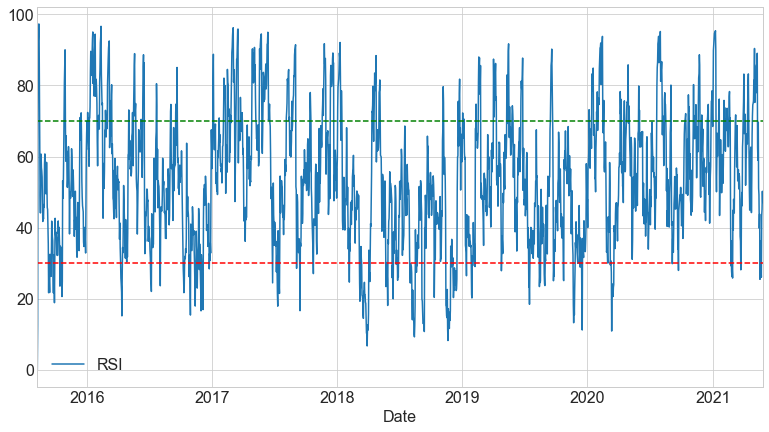

In [39]:
# View RSI
RSI1.plot()
plt.axhline(y = 70, color ="green", linestyle ="--")
plt.axhline(y = 30, color ="red", linestyle ="--")
plt.legend(['RSI'])
plt.show()